In [1]:
from datasets import flickr8k_parse
from models import decoder, image_preprocessing, predict, transfer_models

import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import text_processing

%matplotlib inline

D:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '

## Training and validation loss charts

In [2]:
def get_losses(csv_path):
    """
    Returns losses from a callback csv file
    
    :param: csv_path - path to csv file with losses
    """
    callback_df = pd.read_csv(csv_path)
    return callback_df['loss'], callback_df['val_loss']

In [3]:
gru_path = './model_files/callbacks/VGG16_GRU_flickr8k_2l_32b.csv'
gru_bn_dr_path = './model_files/callbacks/VGG16_GRU_flickr8k_2l_32b_bn_dr.csv'
lstm_path = './model_files/callbacks/VGG16_LSTM_flickr8k_2l_32b_bn_dr.csv'
bahdanau_path = './model_files/callbacks/VGG16_LSTM_flickr8k_2l_32b_bn_dr_attn_bahdanau.csv'
scaled_dot_path = './model_files/callbacks/VGG16_LSTM_flickr8k_2l_32b_bn_dr_attn_scaled_dot.csv'

In [4]:
gru_train_loss, gru_val_loss = get_losses(gru_path)
gru_bn_dr_train_loss, gru_bn_dr_val_loss = get_losses(gru_bn_dr_path)
lstm_train_loss, lstm_val_loss = get_losses(lstm_path)
bahdanau_train_loss, bahdanau_val_loss = get_losses(bahdanau_path)
scaled_dot_train_loss, scaled_dot_val_loss = get_losses(scaled_dot_path)

In [5]:
bahdanau_val_loss

0     11.087772
1      2.932160
2      3.509282
3      1.540231
4      1.368435
5      1.416689
6      1.463712
7      1.461219
8      1.230340
9      1.396299
10     1.405032
11     1.296784
12     1.328968
13     1.382582
14     1.331822
15     1.315039
16     1.331377
17     1.283841
18     1.314942
19     1.268190
Name: val_loss, dtype: float64

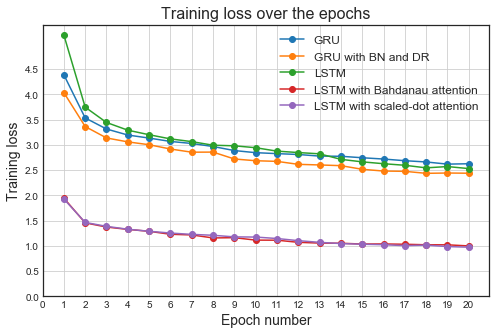

In [6]:
sns.set_style('white')
x_range = np.arange(1, 21)

plt.figure(figsize=(8,5))

plt.plot(x_range, gru_train_loss, label='GRU', marker='o')
plt.plot(x_range, gru_bn_dr_train_loss, label='GRU with BN and DR', marker='o')
plt.plot(x_range, lstm_train_loss, label='LSTM', marker='o')
plt.plot(x_range, bahdanau_train_loss, label='LSTM with Bahdanau attention', marker='o')
plt.plot(x_range, scaled_dot_train_loss, label='LSTM with scaled-dot attention', marker='o')

plt.xticks(np.arange(0, 21))
plt.yticks(np.arange(0, 5, 0.5))

plt.xlabel('Epoch number', fontsize=14)
plt.ylabel('Training loss', fontsize=14)
plt.title('Training loss over the epochs', fontsize=16)
plt.grid()
plt.legend(fontsize=12)
plt.show()

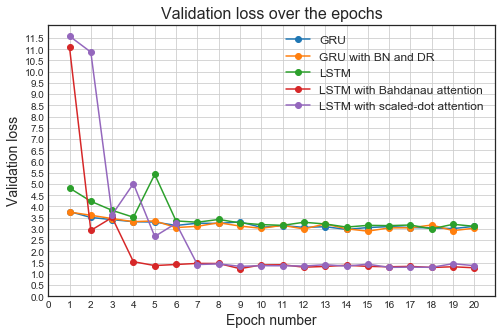

In [7]:
sns.set_style('white')
x_range = np.arange(1, 21)

plt.figure(figsize=(8,5))

plt.plot(x_range, gru_val_loss, label='GRU', marker='o')
plt.plot(x_range, gru_bn_dr_val_loss, label='GRU with BN and DR', marker='o')
plt.plot(x_range, lstm_val_loss, label='LSTM', marker='o')
plt.plot(x_range, bahdanau_val_loss, label='LSTM with Bahdanau attention', marker='o')
plt.plot(x_range, scaled_dot_val_loss, label='LSTM with scaled-dot attention', marker='o')

plt.xticks(np.arange(0, 21))
plt.yticks(np.arange(0, 12, 0.5))

plt.xlabel('Epoch number', fontsize=14)
plt.ylabel('Validation loss', fontsize=14)
plt.title('Validation loss over the epochs', fontsize=16)
plt.grid()
plt.legend(fontsize=12)
plt.show()

## Analysis of the generated captions

In [8]:
gru_path = './model_files/captions/VGG16_GRU_flickr8k_2l_32b.txt'
gru_bn_dr_path = './model_files/captions/VGG16_GRU_flickr8k_2l_32b_bn_dr.txt'
lstm_path = './model_files/captions/VGG16_LSTM_flickr8k_2l_32b_bn_dr.txt'
bahdanau_path = './model_files/captions/VGG16_LSTM_flickr8k_2l_32b_bn_dr_attn_bahdanau_3b.txt'
scaled_dot_path = './model_files/captions/VGG16_LSTM_flickr8k_2l_32b_bn_dr_attn_scaled_dot.txt'

In [9]:
def read_captions(path):
    """
    Reads captions from a file corresponding do a given file
    """
    with open(path, 'r') as captions_file:
        captions = [caption[:-1] for caption in captions_file.readlines()]
    return captions

def get_captions_vocab(captions):
    vocab = text_processing.Vocabulary()
    for caption in captions:
        for word in caption.split():
            vocab.add_word(word)
    return vocab

In [10]:
train_vocab = text_processing.Vocabulary()
train_vocab.load_vocabulary('./vocabulary/word_to_id.pickle', './vocabulary/id_to_word.pickle', './vocabulary/word_counter.pickle')

### Diversity of captions

In [11]:
train_vocab.number_of_words

7373

In [12]:
gru_captions = read_captions(gru_path)
gru_vocab = get_captions_vocab(gru_captions)
gru_vocab.number_of_words

117

In [13]:
gru_bn_dr_captions = read_captions(gru_bn_dr_path)
gru_bn_dr_vocab = get_captions_vocab(gru_bn_dr_captions)
gru_bn_dr_vocab.number_of_words

251

In [14]:
lstm_captions = read_captions(lstm_path)
lstm_vocab = get_captions_vocab(lstm_captions)
lstm_vocab.number_of_words

254

In [15]:
bahdanau_captions = read_captions(bahdanau_path)
bahdanau_vocab = get_captions_vocab(bahdanau_captions)
bahdanau_vocab.number_of_words

249

In [16]:
scaled_dot_captions = read_captions(scaled_dot_path)
scaled_dot_vocab = get_captions_vocab(scaled_dot_captions)
scaled_dot_vocab.number_of_words

269

### Most frequent words

In [17]:
num_words = 10
pct = True

In [18]:
sorted_dict = sorted(train_vocab.word_counter.items(), key=lambda x: x[1], reverse=True) 
ignore_list = ['<sos>', '<eos>']
sum_words = 0
for pair in sorted_dict:
    if pair[0] not in ignore_list:
        sum_words += pair[1]
print(sum_words)

324466


In [19]:
print(train_vocab.get_word_frequency('woman') / sum_words)
print(train_vocab.get_word_frequency('bird') / sum_words)

0.007837492988479532
0.00045613407876326026


In [20]:
train_vocab.get_most_frequent_words(num_words, pct)

['a - 14.42%',
 'in - 4.34%',
 'the - 4.16%',
 'on - 2.47%',
 'is - 2.13%',
 'and - 2.06%',
 'dog - 1.9%',
 'with - 1.78%',
 'man - 1.66%',
 'of - 1.53%']

In [21]:
gru_vocab.get_most_frequent_words(num_words, pct)

['a - 24.65%',
 'in - 6.33%',
 'is - 5.91%',
 'man - 4.96%',
 'shirt - 4.1%',
 'white - 3.92%',
 'on - 3.06%',
 'and - 2.64%',
 'black - 2.25%',
 'dog - 2.04%']

In [22]:
gru_bn_dr_vocab.get_most_frequent_words(num_words, pct)

['a - 21.61%',
 'in - 6.29%',
 'is - 6.18%',
 'man - 3.69%',
 'shirt - 3.4%',
 'the - 2.83%',
 'on - 2.74%',
 'and - 2.59%',
 'red - 2.42%',
 'dog - 2.31%']

In [23]:
lstm_vocab.get_most_frequent_words(num_words, pct)

['a - 23.03%',
 'in - 6.19%',
 'is - 5.9%',
 'man - 3.85%',
 'on - 3.64%',
 'shirt - 2.64%',
 'the - 2.52%',
 'and - 2.48%',
 'of - 1.81%',
 'red - 1.72%']

In [24]:
bahdanau_vocab.get_most_frequent_words(num_words, pct)

['a - 21.51%',
 'in - 6.91%',
 'is - 5.79%',
 'shirt - 3.29%',
 'man - 2.99%',
 'the - 2.89%',
 'on - 2.74%',
 'and - 2.68%',
 'of - 2.26%',
 'white - 2.11%']

In [25]:
scaled_dot_vocab.get_most_frequent_words(num_words, pct)

['a - 20.95%',
 'in - 6.16%',
 'is - 5.61%',
 'the - 3.39%',
 'man - 3.32%',
 'on - 3.1%',
 'and - 3.1%',
 'shirt - 2.89%',
 'dog - 2.22%',
 'of - 2.16%']

### Beam size analysis

In [26]:
attn = True
bahdanau_weights_path = './model_files/weights/VGG16_LSTM_flickr8k_2l_32b_bn_dr_attn_bahdanau.hdf5'
bahdanau_model_path = './model_files/models/VGG16_LSTM_2l_bn_dr_attn_bahdanau.json'
scaled_weights_path = './model_files/weights/VGG16_LSTM_flickr8k_2l_32b_bn_dr_attn_scaled_dot.hdf5'
scaled_model_path = './model_files/models/VGG16_LSTM_2l_bn_dr_attn_scaled_dot.json'

In [27]:
decoder_model_bahdanau = decoder.load_model(bahdanau_model_path, bahdanau_weights_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [28]:
VGG_transfer_model, VGG_image_size = transfer_models.vgg_model(attn=attn)

In [29]:
train_vocab = text_processing.Vocabulary()
train_vocab.load_vocabulary('./vocabulary/word_to_id.pickle', './vocabulary/id_to_word.pickle', './vocabulary/word_counter.pickle')

In [30]:
images_path = 'D:/Flickr8k/images/'
captions_file = 'D:/Flickr8k/annotations/Flickr8k.token.txt'
test_txt_path = 'D:/Flickr8k/annotations/Flickr_8k.testImages.txt'
filenames_with_all_captions = flickr8k_parse.generate_filenames_with_all_captions(captions_file, images_path)
test_filenames_with_all_captions = flickr8k_parse.generate_set(test_txt_path, filenames_with_all_captions, images_path)
test_filenames = list(test_filenames_with_all_captions.keys())

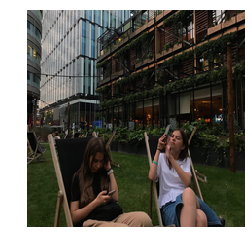

a man in a black shirt is sitting on a bench with a woman in a blue shirt


In [35]:
tmp_filename = 'C:/Users/User/Desktop/test_photos/lay_di.jpg'
tmp_res = predict.generate_caption(tmp_filename, 
                                   VGG_image_size, 
                                   decoder_model_bahdanau, 
                                   VGG_transfer_model, 
                                   train_vocab, 
                                   beam_size=1, 
                                   attn=attn, 
                                   get_weights=False)
img = image_preprocessing.image_preprocessing(tmp_filename, VGG_image_size)
plt.imshow(img)
plt.axis('off')
plt.show()
captions = tmp_res[0]
for caption in captions:
    print(" ".join(caption))

In [36]:
np.random.seed(20)
number_of_samples = 1
indices = list(np.random.randint(0, len(test_filenames), size=number_of_samples))
print(indices)
paths = [test_filenames[ind] for ind in indices]
print(paths)

[355]
['D:/Flickr8k/images/2968182121_b3b491df85.jpg']


In [37]:
beam_sizes = [1, 3, 5]
caption_dict = {}
for filename in paths:
    caption_dict[filename] = []
    for beam_size in beam_sizes:
        result = predict.generate_caption(filename, VGG_image_size, decoder_model_bahdanau, VGG_transfer_model, train_vocab, beam_size=beam_size, attn=attn, get_weights=False)
        captions, probs = result
        caption_dict[filename].append((captions, probs))

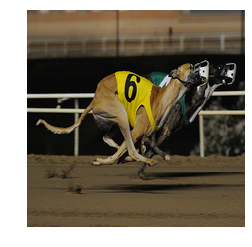

beam size 1:
a greyhound dog wearing a yellow racing -1.0133
beam size 3:
a greyhound racing on a track -0.6542
a greyhound dog wearing a yellow racing -1.1399
a greyhound dog wearing a yellow shirt is racing -1.4654
beam size 5:
a greyhound racing on a track -0.6542
a greyhound greyhound in a race -0.7243
a greyhound in a race -0.7462
a greyhound dog wearing a yellow racing -1.1399
a greyhound dog wearing a yellow shirt is racing -1.4654


In [38]:
for filename in paths:
    plt.figure()
    img = image_preprocessing.image_preprocessing(filename, VGG_image_size)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    for i, result in enumerate(caption_dict[filename]):
        print("beam size {}:".format(beam_sizes[i]))
        for i, caption in enumerate(result[0]):
            print(" ".join(caption), round(result[1][i],4))

### Attention visualisation

In [60]:
decoder_model_scaled = decoder.load_model(scaled_model_path, scaled_weights_path)

In [93]:
filename = 'D:/Flickr8k/images//109823394_83fcb735e1.jpg'
beam_size = 3

In [94]:
result_bahdanau = predict.generate_caption(filename, VGG_image_size, decoder_model_bahdanau, VGG_transfer_model, train_vocab, beam_size=beam_size, attn=attn, get_weights=True)
result_scaled = predict.generate_caption(filename, VGG_image_size, decoder_model_scaled, VGG_transfer_model, train_vocab, beam_size=beam_size, attn=attn, get_weights=True)

In [95]:
captions_bahdanau, _, attn_weights_bahdanau = result_bahdanau
captions_scaled, _, attn_weights_scaled = result_scaled

three
people
are
riding
a
dirt
bike
in
the
dirt


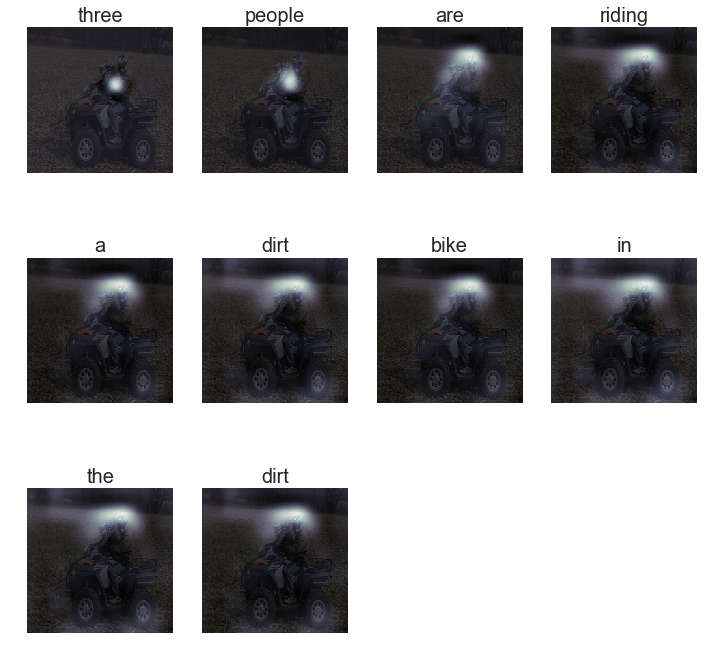

In [96]:
predict.get_weights_plot(captions_bahdanau[0], attn_weights_bahdanau, filename, mode='show')

In [ ]:
predict.get_weights_plot(captions_scaled[0], attn_weights_scaled, filename, mode='show')